# <a name="C0">Partie III. Proposition de contrat de maintenance<a>

**Importation des modules python**

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
# Load the dataset
simulation_df = pd.read_csv("simulation_data.csv",index_col=0)
simulation_df.sample(10)

,customer_unique_id,order_purchase_timestamp,Recency,Frequency,Montant,mean_review_score,Cluster,rfm_segment,Recency_score,Frequency_score,Montant_score,rfm_score,customer_city,customer_state
52242,ccdc8077ddf73967d6c6e658cced7d4a,2017-12-25 20:18:34,246,1,105.80,4.0,1,Perdus,3,1,3,313,barra do corda,MA
19754,4d531a68877fe93bb78417a20d36047a,2017-10-16 11:28:49,317,1,689.44,5.0,3,A réactiver,3,1,4,314,florianopolis,SC
57655,e2296f1411e9227cf190016c46a52fa6,2018-07-05 00:35:45,55,1,193.84,5.0,3,Champions,1,1,4,114,lencois paulista,SP
19936,4e0a2e5042d2a26c28a67b4f4664cc62,2018-05-09 13:54:21,112,1,137.61,5.0,3,Loyaux,1,1,3,113,florestopolis,PR
38968,991669f489a5bd99e998ce6b5a90dcb5,2017-12-02 12:30:05,270,1,156.22,5.0,3,Perdus,3,1,3,313,campinas,SP
22729,58c2385a00210b1ce3ad1542d4ab16fe,2017-12-19 19:34:25,252,1,659.84,1.0,2,A réactiver,3,1,4,314,quixada,CE
12915,328eb9bf2f55abdcd28a7632138c5278,2017-01-20 11:38:56,586,1,138.35,5.0,0,Perdus,4,1,3,413,sao paulo,SP
18955,4a3befd6d52937c59c535f683c0cc5d8,2018-03-06 14:44:08,176,1,20.00,4.0,1,Loyalistes potentiels,2,1,1,211,cotia,SP
6119,17b4caf45618845bac7a29610ee921ce,2018-07-01 19:51:47,58,1,154.05,5.0,3,Loyaux,1,1,3,113,sao joao da boa vista,SP
16044,3ea1c0d5c92973751f10c90168fb2f52,2017-11-24 01:24:10,278,1,33.85,5.0,1,Perdus,3,1,1,311,ubatuba,SP


In [3]:
# Convert date column to datetime
simulation_df["order_purchase_timestamp"] = pd.to_datetime(simulation_df["order_purchase_timestamp"],
                                                           format="%Y-%m-%d %H:%M:%S")

In [4]:
simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65129 entries, 0 to 65128
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        65129 non-null  object        
 1   order_purchase_timestamp  65129 non-null  datetime64[ns]
 2   Recency                   65129 non-null  int64         
 3   Frequency                 65129 non-null  int64         
 4   Montant                   65129 non-null  float64       
 5   mean_review_score         65129 non-null  float64       
 6   Cluster                   65129 non-null  int64         
 7   rfm_segment               65129 non-null  object        
 8   Recency_score             65129 non-null  int64         
 9   Frequency_score           65129 non-null  int64         
 10  Montant_score             65129 non-null  int64         
 11  rfm_score                 65129 non-null  int64         
 12  customer_city     

In [5]:
simulation_data = simulation_df[["customer_unique_id","order_purchase_timestamp","Recency",
                                 "Montant","mean_review_score","Cluster"]]

In [6]:
simulation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65129 entries, 0 to 65128
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        65129 non-null  object        
 1   order_purchase_timestamp  65129 non-null  datetime64[ns]
 2   Recency                   65129 non-null  int64         
 3   Montant                   65129 non-null  float64       
 4   mean_review_score         65129 non-null  float64       
 5   Cluster                   65129 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 3.5+ MB


In [7]:
# Checking data in 2016
simulation_data.loc[simulation_data.order_purchase_timestamp.dt.year==2016]

,customer_unique_id,order_purchase_timestamp,Recency,Montant,mean_review_score,Cluster
48,0032c76b20340da25249092a268ce66c,2016-10-06 11:32:00,692,144.94,4.0,0
1586,0636d30c77f0f9cfad81f1c9b58c791f,2016-10-08 02:18:43,690,971.96,4.0,0
1722,06bdfbbe1857c3c925ec81abfb1c9666,2016-10-04 23:39:01,693,196.27,5.0,0
2109,0829f7df6577d5a4b65439bea701405f,2016-10-04 13:15:46,694,267.49,3.0,0
2293,08da95f931937b2c20f5225f2e6c93b0,2016-10-10 15:37:12,687,80.94,5.0,0
...,...,...,...,...,...,...
63460,f922896769e9517ea3c630f3c8de86d0,2016-10-04 14:23:50,694,62.33,5.0,0
63568,f99053da7416fd6d626451cd49e44e0f,2016-10-04 19:30:28,693,40.79,5.0,0
63821,faae4bdf680651e40005ea6f0f90e8b8,2016-10-04 22:15:11,693,65.46,3.0,0
64522,fdaa290acb9eeacb66fa7f979baa6803,2016-10-08 01:28:14,690,1423.55,5.0,0


- Sur l'année 2016, nous n'avons des données que pour le mois d'Octobre. Nous ne considérerons que les données sur les années 2017 et 2018.

In [8]:
# Years 2017 - 2018
simulation_data = simulation_data.loc[simulation_data.order_purchase_timestamp.dt.year!=2016]

In [9]:
print(f"Période de commandes considérée : du {simulation_data['order_purchase_timestamp'].min()} au {simulation_data['order_purchase_timestamp'].max()}")

Période de commandes considérée : du 2017-01-05 11:56:06 au 2018-08-29 15:00:37


In [10]:
# The number of month convered
time_period = int((simulation_data.order_purchase_timestamp.max() - 
                  simulation_data.order_purchase_timestamp.min())/np.timedelta64(1,"M"))

print(f"The full order period is {time_period} months.")

The full order period is 19 months.


## Stabilité dans le temps du modèle KMeans en s'appuyant sur le score ARI

- Nous regardons si notre modèle KMeans est stable dans le temps et détectons la période à laquelle les clients changent de cluster. 

**Initialisation avec des données sur un an (l'année 2017).**

On va utiliser l'année 2017 pour entraîner notre modèle initial et ensuite itérer la modélisation par semaine. Le but est de comparer les résultats de prédiction des clusters entre le modèle initial et les nouveaux modèles.

In [11]:
# Create a column for the weeks
simulation_data["year_week"] = pd.to_datetime(simulation_data["order_purchase_timestamp"]).dt.to_period("W")
# Keep only the last day in the week
simulation_data["year_week"] = simulation_data["year_week"].apply(lambda x: x.end_time.date())
# Dataset with only kmeans features
data = simulation_data[["Recency","Montant","mean_review_score","year_week"]]
data = data.sort_values("year_week",ascending=True).reset_index(drop=True)

# Dataset for year 2017
data_2017 = simulation_data.loc[simulation_data.order_purchase_timestamp.dt.year==2017].reset_index(drop=True)
data_2017 = data_2017[["Recency","Montant","mean_review_score",
                       "year_week"]].sort_values("year_week",ascending=True).reset_index(drop=True)
data_2017

,Recency,Montant,mean_review_score,year_week
0,600,17.62,5.0,2017-01-08
1,597,256.79,5.0,2017-01-08
2,600,91.92,3.0,2017-01-08
3,601,19.62,5.0,2017-01-08
4,598,25.10,5.0,2017-01-08
...,...,...,...,...
28753,242,95.02,4.0,2017-12-31
28754,242,116.94,4.0,2017-12-31
28755,245,69.61,5.0,2017-12-31
28756,246,97.17,4.0,2017-12-31


- Nous créons succéssivement différents jeux de données en rajoutant une semaine de données à chaque itération.

In [12]:
# Creating different datasets shifted by one week each time
data_weeks = dict()

last_date = data_2017.year_week.max()
i=1
while last_date<data.year_week.max():
    last_date=last_date+DateOffset(weeks=1)
    data_weeks[i]=data[data["year_week"]<last_date]
    i += 1

In [13]:
# First four datatsets we get
for i in range(1,5):
    print(data_weeks[i])

       Recency  Montant  mean_review_score   year_week
0          601    19.62                5.0  2017-01-08
1          600    91.92                3.0  2017-01-08
2          601    18.62                5.0  2017-01-08
3          598    84.59                3.0  2017-01-08
4          600    50.95                4.0  2017-01-08
...        ...      ...                ...         ...
28753      244   257.44                4.0  2017-12-31
28754      242    50.00                5.0  2017-12-31
28755      247   126.18                5.0  2017-12-31
28756      243   136.18                1.0  2017-12-31
28757      241    29.00                5.0  2017-12-31

[28758 rows x 4 columns]
       Recency  Montant  mean_review_score   year_week
0          601    19.62                5.0  2017-01-08
1          600    91.92                3.0  2017-01-08
2          601    18.62                5.0  2017-01-08
3          598    84.59                3.0  2017-01-08
4          600    50.95                

**Standardisation des données de l'année 2017**

In [14]:
# Standardization 
scaler0 = StandardScaler()

data_2017_toscale = data_2017.iloc[:,:-1]

scaler0.fit(data_2017_toscale)

cols_scaled = scaler0.transform(data_2017_toscale)

# Scaled dataframe
X_2017_scaled = pd.DataFrame(cols_scaled,index=data_2017_toscale.index,columns=data_2017_toscale.columns)
X_2017_scaled

,Recency,Montant,mean_review_score
0,2.353320,-0.638029,0.645876
1,2.321676,0.469999,0.645876
2,2.353320,-0.293811,-1.018943
3,2.363868,-0.628763,0.645876
4,2.332224,-0.603375,0.645876
...,...,...,...
28753,-1.422871,-0.279449,-0.186533
28754,-1.422871,-0.177898,-0.186533
28755,-1.391227,-0.397169,0.645876
28756,-1.380679,-0.269489,-0.186533


- **Entrainement du modèle initial sur les données de l'année 2017.**

In [21]:
# Instantiate the initial clustering model 
kmeans0 = KMeans(4,init="k-means++",random_state=42)
kmeans0_init0 = kmeans0.fit(X_2017_scaled)

- **Calcul du score ARI sur chaque itération d'une semaine.**

In [22]:
# List of ARI scores
ari_score = []

for i in range(1,len(data_weeks)+1):
    # Iterated StandardScaler, modelization and prediction of clusters
    scaler1 = StandardScaler()
    data_weeks_scaled1 = pd.DataFrame(scaler1.fit_transform(data_weeks[i].iloc[:,:-1]))
    kmeans0_init1 = kmeans0.fit(data_weeks_scaled1)
    clusters1 = kmeans0_init1.predict(data_weeks_scaled1)
    
    # Predict the clusters with the initial model
    data_weeks_scaled0 = pd.DataFrame(scaler0.transform(data_weeks[i].iloc[:,:-1]))
    clusters0 = kmeans0_init0.predict(data_weeks_scaled0)
    
    # ARI score
    ari_score.append(adjusted_rand_score(clusters1, clusters0))

In [23]:
# ARI Score for every week 
periodes = ["week"+str(i) for i in range(1,len(data_weeks)+1)]
ari_score_per_week = pd.DataFrame({"periode":periodes,"ARI Score":ari_score})
ari_score_per_week

,periode,ARI Score
0,week1,1.000000
1,week2,0.966699
2,week3,0.925536
3,week4,0.883787
4,week5,0.859387
5,week6,0.831642
6,week7,0.809630
7,week8,0.790458
8,week9,0.768135
9,week10,0.749104


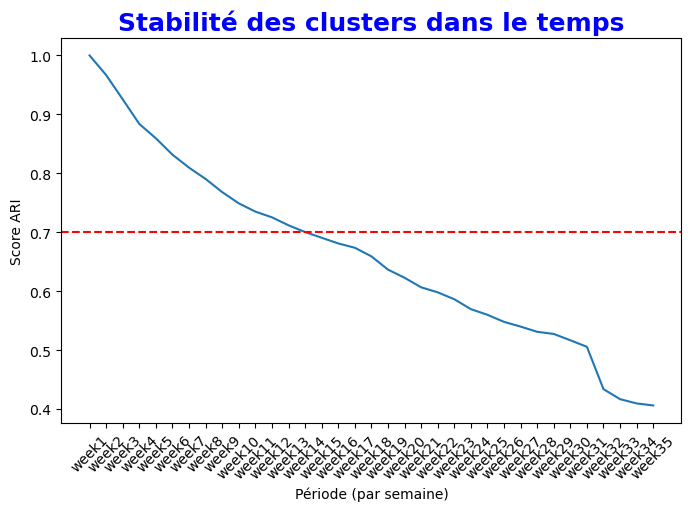

In [29]:
# Plotting ARI score
fig = plt.figure(figsize=(8,5))
sns.lineplot(data=ari_score_per_week,x="periode",y="ARI Score")

# Threshold value of the ARI score
plt.axhline(y=0.7,c="r",linestyle="--")

plt.xlabel("Période (par semaine)")
plt.xticks(rotation=45)
plt.ylabel("Score ARI")
plt.title("Stabilité des clusters dans le temps",fontsize=18,color="b",fontweight="bold")
plt.show()

## **Contrat de maintenance :**

- On remarque que le score ARI décroît rapidement tout au long des semaines et atteint une valeur inférieur à 0.7 au bout de 13 semaines de mise en production.
- Il serait donc judicieux de réaliser une maintenance du modèle après 13 semaines de son déploiement pour mettre à jour les clusters afin de garder un score ARI suffisamment grand et donc des clusters stables.